In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scsavailability as scs

from scsavailability import features as feat, model as md, plotting as pt

In [2]:
path = '../data/'

In [3]:
at = pd.read_csv(path+'active_totes_20201123.csv')
av = pd.read_csv(path+'Availability_with_Grey&Blue_1811-2511.csv')
fa = pd.read_csv(path + 'scs_tote_matched.csv')

In [4]:
at = feat.pre_process_AT(at)

Active Totes Preprocessed


In [5]:
av = feat.pre_process_av(av)

Quadrants Assigned
Modules Assigned
Availability data pre-processed


In [6]:
fa = feat.preprocess_faults(fa,remove_same_location_faults = True)

duplicated location faults removed - max duration kept
Faults Preprocessed


c:\users\chris.hughes\documents\git\scs\scsavailability\features.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fa['Duration'] = pd.to_timedelta(fa['Duration'].str.slice(start=2))
c:\users\chris.hughes\documents\git\scs\scsavailability\features.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fa['Duration'] = fa['Duration'].dt.total_seconds()


In [7]:
fa_floor = feat.floor_shift_time_fa(fa, shift=0)

Time shifted by 0m


In [8]:
fa_sel = feat.fault_select(fa_floor, select_level = 'Tote Colour', selection = ['Blue','Both'])

fa_agg = feat.faults_aggregate(fa_sel,fault_agg_level='code', agg_type = 'count')

Faults aggregated


In [9]:
av,at = feat.av_at_select(av, at, remove_high_AT = False)

av_agg = feat.aggregate_availability(av, agg_level = 'Module')
at_agg = feat.aggregate_totes(at, agg_level = 'Module')

Availability data aggregated


In [16]:
df = feat.merge_av_fa_at(av_agg ,at_df=at_agg, fa_df = fa_agg, target = 'Blue Tote Loss',faults=True, totes = True, agg_level = 'Module')

Datasets merged


In [17]:
df.head(5)

,timestamp,Blue Tote Loss,C05,C0501STA002,C0501STA012,C0502ACH023,C0502RDC040,C0502STA024,C0502STA026,C0502STA030,...,C36,C38,C40,C42,C44,C46,C48,C50,SCSM22,TOTES
0,2020-11-18 11:00:00,0.506000,2,0,0,0,0,0,1,0,...,0,2,0,0,2,0,0,0,5,28.833333
1,2020-11-18 11:00:00,0.151333,2,0,0,0,0,0,1,0,...,0,2,0,0,2,0,0,0,5,47.133333
2,2020-11-18 11:00:00,0.002000,2,0,0,0,0,0,1,0,...,0,2,0,0,2,0,0,0,5,71.300000
3,2020-11-18 11:00:00,0.016000,2,0,0,0,0,0,1,0,...,0,2,0,0,2,0,0,0,5,61.366667
4,2020-11-18 11:00:00,0.348000,2,0,0,0,0,0,1,0,...,0,2,0,0,2,0,0,0,5,31.800000


In [18]:
df = df[df['TOTES']<60].reset_index(drop=True)

In [19]:
X,y = md.gen_feat_var(df)

Feature Coefficient Ranking: 
 
    Coefficients      Feature
0 -2.245911e+10  C0502RDC040
1 -1.885231e+10  C0502ACH023
2 -7.997264e+09  C0501STA002
3 -6.623153e+09  C0901STA012
4 -5.089024e+09  C1602ACH090
5 -4.789652e+09  C0804STA149
6 -4.779122e+09  C1102ACH033
7 -4.272686e+09  C2301ACL021
8 -4.238711e+09  C0704ACL135
9 -4.152227e+09  C0502STA030

Regression Metrics: 
 
           LM Metrics
MAE         0.081005
MSE         0.011215
RMSE        0.105902
MAPE%            inf
ACC%            -inf
R2_Train    0.720426
R2_Pred     0.580434

Cross Validation Scores LinearRegression(): 
 
        R2 Scores
1       0.646174
2       0.511125
3       0.559401
4       0.685725
5       0.585456
6       0.665339
7       0.638576
8       0.672617
9       0.696947
10      0.647503
Mean    0.630886
STD     0.056908


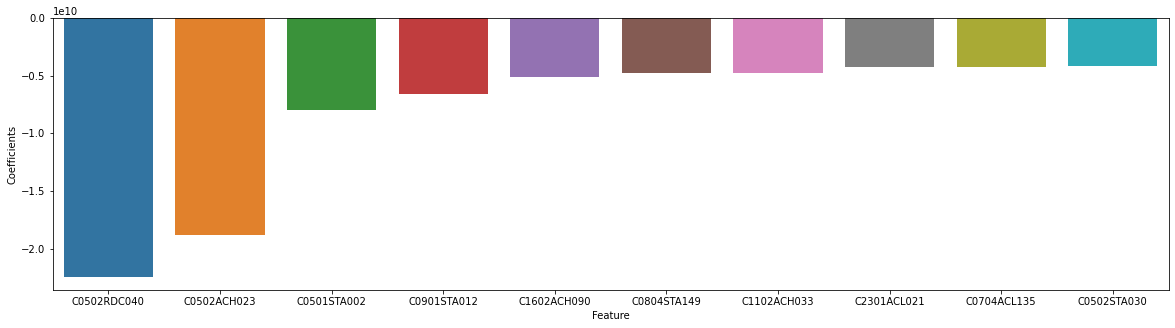

In [20]:
X_train, X_test, y_train, y_test = md.split(X,y,test_size=0.3,random_state=101)

#RF_mdl,predictions_RF=md.run_RF_model(X_train, X_test, y_train, y_test,num_trees=100, criterion = 'mse', max_depth=None, dtree=False)

#X_sel_rf = md.select_features(X, X_train, y_train, RF_mdl, thres = np.inf(), max_feat=1000)

Linear_mdl,predictions_LM=md.run_LR_model(X_train, X_test, y_train, y_test)

#X_sel_lm = md.select_features(X, X_train, y_train, Linear_mdl, thres = np.inf(), max_feat=1000)

cv_R2 = md.cross_validate_r2(Linear_mdl, X, y, n_folds = 10, shuffle = True, random_state = 101)

# cv_R2 = md.cross_validate_r2(RF_mdl, X, y, n_folds = 10, shuffle = True, random_state = 101)

In [21]:
df

,timestamp,Blue Tote Loss,C05,C0501STA002,C0501STA012,C0502ACH023,C0502RDC040,C0502STA024,C0502STA026,C0502STA030,...,C36,C38,C40,C42,C44,C46,C48,C50,SCSM22,TOTES
0,2020-11-18 11:00:00,0.506000,2,0,0,0,0,0,1,0,...,0,2,0,0,2,0,0,0,5,28.833333
1,2020-11-18 11:00:00,0.151333,2,0,0,0,0,0,1,0,...,0,2,0,0,2,0,0,0,5,47.133333
2,2020-11-18 11:00:00,0.348000,2,0,0,0,0,0,1,0,...,0,2,0,0,2,0,0,0,5,31.800000
3,2020-11-18 11:00:00,0.205333,2,0,0,0,0,0,1,0,...,0,2,0,0,2,0,0,0,5,52.383333
4,2020-11-18 11:00:00,0.326576,2,0,0,0,0,0,1,0,...,0,2,0,0,2,0,0,0,5,39.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1570,2020-11-23 09:00:00,0.035833,1,0,2,0,0,0,0,0,...,0,0,0,5,1,0,6,0,6,55.672414
1571,2020-11-23 09:00:00,0.375009,1,0,2,0,0,0,0,0,...,0,0,0,5,1,0,6,0,6,45.672414
1572,2020-11-23 09:00:00,0.244000,1,0,2,0,0,0,0,0,...,0,0,0,5,1,0,6,0,6,35.896552
1573,2020-11-23 09:00:00,0.208667,1,0,2,0,0,0,0,0,...,0,0,0,5,1,0,6,0,6,54.586207
